In [1]:
from typing import Sequence
from cv2.typing import MatLike
from numpy.typing import NDArray

import warnings
import os.path
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [29]:
!python calibration.py -port 2500

2500


In [2]:
tsukubar_gif = np.array([cv2.imread(os.path.join(os.path.dirname(os.getcwd()),
           "data_segs", f"tsukuba_{i}_delay-0.15s.png")) for i in range(8)])

tsukubar_gif.shape

(8, 288, 384, 3)

# Show image ultils

In [3]:
""" FROM CPV LAB 1"""


def draw_quadrange(x, y, color=None, limX=None, limY=None) -> None:
    """draw a regtangle of points
    Bundle a scatter, color, xlim, ylim in one function

    Args:
        x, y (np array shape): data positoin
        color (str, optional): color of points.
        limX , limy (Iterable[int]): matplotlib Xlim Ylim
    """

    plt.scatter(x, y, color=color)

    if limX is not None and limY is not None:
        plt.xlim(limX)
        plt.ylim(limY)


""" FROM CPV LAB 2 """


def draw_2_img(im1: MatLike, im2: MatLike, label1: str = None, label2: str = None,  cmap="grey", figsize: tuple[int, int] = None, sharexy: bool = False):
    fig, axes = plt.subplots(1, 2, figsize=figsize,
                             sharex=sharexy, sharey=sharexy)

    # configuration
    axes[0].set_title(label1)
    axes[1].set_title(label2)

    axes[0].imshow(im1, cmap=cmap)
    axes[1].imshow(im2, cmap=cmap)

    return fig, axes


def cv2_imshow(img, winname=str()) -> None:
    cv2.imshow(winname, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def figure_to_img(fig):
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    return cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)


""" FROM CPV LAB 3"""


def show_draw_many_imgs(imgs: Sequence[MatLike], labels: None|Sequence[str] = None, cmap="grey", figsize: tuple[int, int] = None, sharexy: bool = False):
    """Extension to draw_2_img"""
    if labels is not None and len(imgs) != len(labels): warnings.warn(f"Images and labels should have the same length. Got {len(imgs)} != {len(labels)}", RuntimeWarning)

    fig, axes = plt.subplots(1, len(imgs), figsize=figsize,
                             sharex=sharexy, sharey=sharexy)

    for i in range(len(axes)):
        axes[i].set_title(labels[i] if labels is not None and i < len(labels) else None)
        axes[i].imshow(imgs[i], cmap=cmap)

    return fig, axes


""" FROM CPV LAB 4"""


def print_debug(*args):
    for i, arg in enumerate(args):
        print("Vaiable", i)
        print(arg)

    print("_"*10)

# OpenCV Steoreo BM

(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

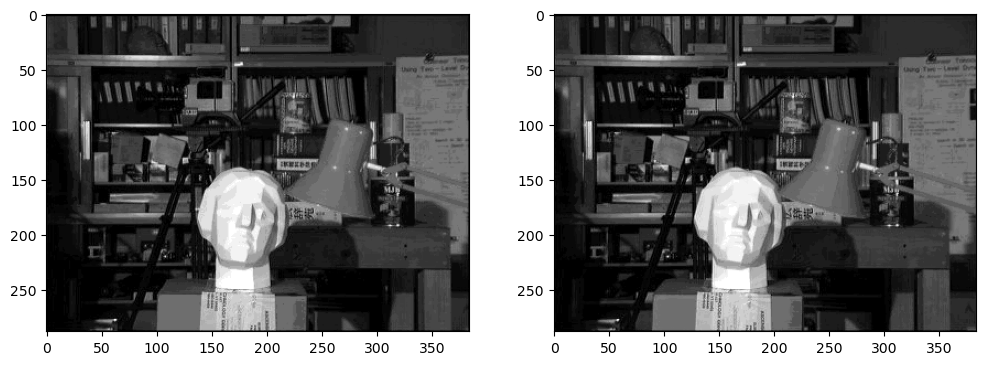

In [4]:
left_image = cv2.cvtColor(tsukubar_gif[0], cv2.COLOR_BGR2GRAY)
right_image = cv2.cvtColor(tsukubar_gif[1], cv2.COLOR_BGR2GRAY)

show_draw_many_imgs([left_image, right_image], figsize=(12,6))

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Ground Truth'}>,
        <Axes: title={'center': 'Open CV'}>], dtype=object))

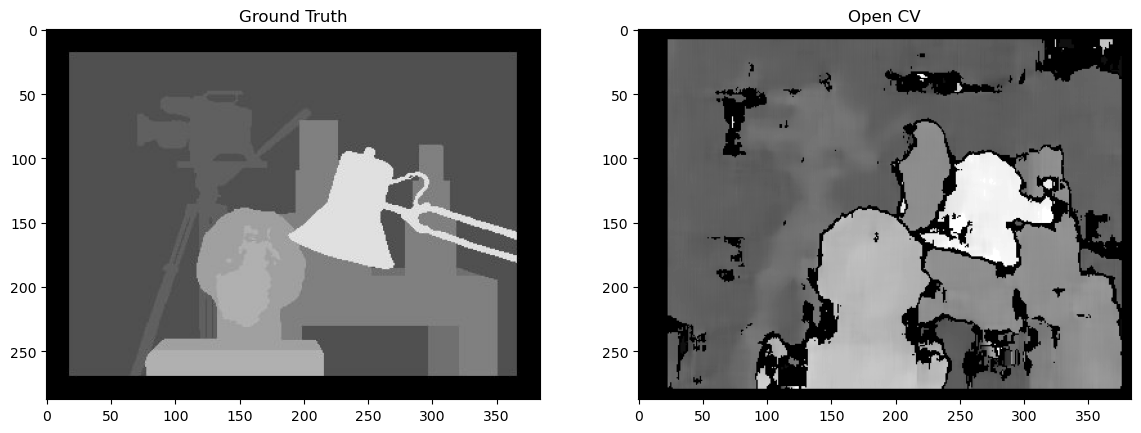

In [5]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=17)
disparity = stereo.compute(left_image, right_image)
disparity = cv2.normalize(disparity, disparity, alpha= 0, beta= 255, norm_type= cv2.NORM_MINMAX, dtype= cv2.CV_8U)

tsukubar_depth = cv2.imread(os.path.join(os.path.dirname(os.getcwd()),
           "data_segs", "tsukuba_ground_truths.png"))
show_draw_many_imgs([tsukubar_depth, disparity], ["Ground Truth", "Open CV"], figsize=(14,7))

## Trying it out real life

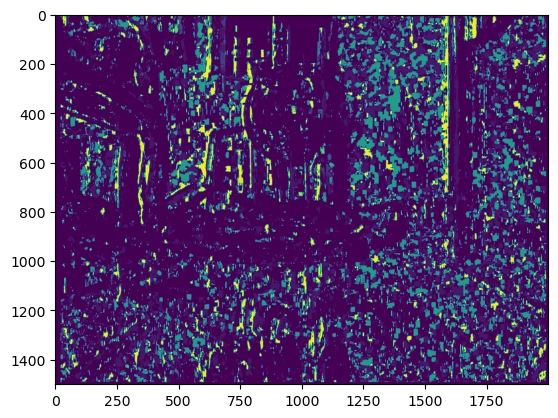

In [6]:
house_left = cv2.imread(os.path.join(os.path.dirname(os.getcwd()),
           "data_segs", f"house_0.png"), cv2.IMREAD_GRAYSCALE)
house_right = cv2.imread(os.path.join(os.path.dirname(os.getcwd()),
           "data_segs", f"house_1.png"), cv2.IMREAD_GRAYSCALE)

house_steoreo = cv2.StereoBM_create(numDisparities= 16, blockSize=17)
house_disparity = house_steoreo.compute(house_left, house_right)
house_disparity = cv2.normalize(house_disparity, house_disparity, alpha= 0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


plt.imshow(house_disparity)

- So we need to find other way

# Feature Matching

In [7]:
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(left_image, None)
kp2, des2 = orb.detectAndCompute(right_image, None)
kp1[:2], des1[:2]

((< cv2.KeyPoint 000001E955E55A70>, < cv2.KeyPoint 000001E957B76700>),
 array([[ 64,  95, 159, 116, 160, 134, 231, 182, 224, 194, 106,  69, 147,
         185,   1,  83, 140, 102,  96,  76, 201, 250, 146,  46, 105, 170,
         100,   0,  72, 240, 226, 155],
        [ 53, 225,  97,  67,  87,  95, 199, 236,  81, 224, 225,  10,  82,
          92,  28, 164,  88, 204,  82, 251,  77, 178, 125,  28,  61,  12,
         133, 118,  99,  62, 210, 230]], dtype=uint8))

280


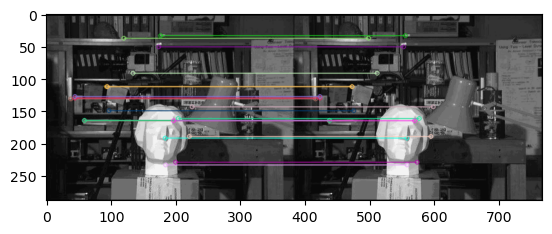

In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1, des2)

# sort them in order of distance
matches = sorted(matches, key = lambda x: x.distance)
print(len(matches))

matched_image = cv2.drawMatches(left_image, kp1, right_image, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_image)

## Brute force with SIFT and BFMatcher.knnMatch() and Ratio Test

In [9]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(left_image, None)
kp2, des2 = sift.detectAndCompute(right_image, None)

bf = cv2.BFMatcher()
matches_knn = bf.knnMatch(des1, des2, k=2)

# apply ratio test
good = list()
for m,n in matches_knn: # k = 2 so there is two varible
    if m.distance < 0.75 * n.distance:
        good.append([m])

good[:2]

[[< cv2.DMatch 000001E957AB5D90>], [< cv2.DMatch 000001E957209370>]]

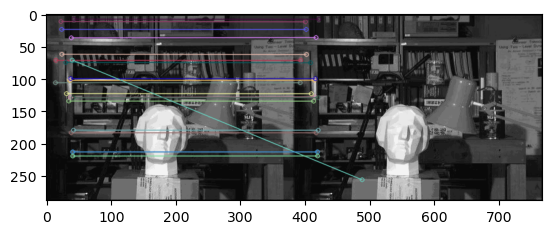

In [10]:
good_image = cv2.drawMatchesKnn(left_image, kp1, right_image, kp2, good[:20], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(good_image)

In [11]:
kp2[matches[0].trainIdx]

< cv2.KeyPoint 000001E9571F6E50>

In [12]:
[kp1[m.queryIdx].pt for m in matches][0]

(138.67347717285156, 8.611837387084961)

In [13]:
np.array([kp1[m.queryIdx].pt for m in matches], dtype = float)[0]

array([138.67347717,   8.61183739])

In [14]:
a = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
b = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)
a.shape, b.shape

((280, 2), (280, 2))

In [15]:
c = np.array(list(zip(a,b)))
c.shape

(280, 2, 2)

In [16]:
a1,b1 = zip(*c)
np.all(np.array(a1) == a)

True

In [36]:
r,c = left_image.shape
r[0]

TypeError: 'int' object is not subscriptable